In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")




In [ ]:
df

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                      1  265000.00               1.9           130    1   
1                      0  263358.03               1.1           136    1   
2                      0  162000.00               1.3           129    1   
3                      0  210000.00               1.9           137    1   
4                      0  327000.00               2.7           116    0   
..                   ...        ...               ...           ...  ...   
294                    1  155000.00               1.1           143    1   
295                    0  270000.00               1.2           139    0   
296                    0  742000.00               0.8           138    0   
297                    0  140000.00               1.4           140    1   
298                    0  395000.00               1.6           136    1   

     smoking  time  DEATH_EVENT  
0          0     4            1  
1          0     6            1  
2          1     7            1  
3          0     7            1  
4          0     8            1  
..       ...   ...          ...  
294        1   270            0  
295        0   271            0  
296        0   278            0  
297        1   280            0  
298        1   285            0  

[299 rows x 13 columns]

##Business understanding:
Enhancing clinical decision-making by providing accurate, interpretable, and efficient heart failure risk predictions to support physicians in patient care.


#Data understanding:
Thirteen (13) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- creatinine phosphokinase  (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction  (percentage)
- high blood pressure: if the patient has hypertension (boolean)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient died during the follow-up period (boolean)




#Explatory data analysis:



Missing Values Per Column:

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


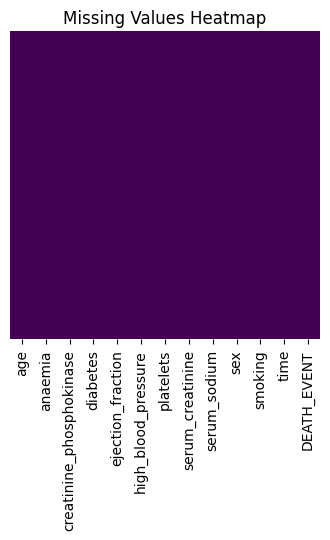

In [ ]:


# Handling Missing Values

print("\nMissing Values Per Column:\n")
print(df.isnull().sum())

# Visualizing missing values using a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


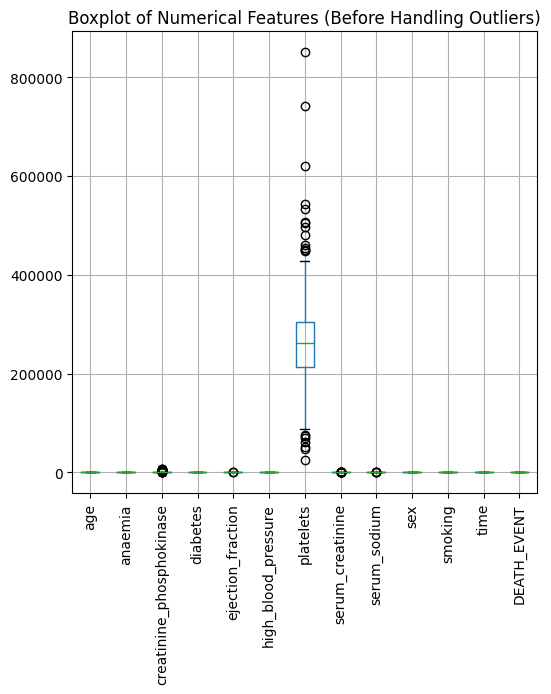

In [ ]:
plt.figure(figsize=(6, 6))
df.boxplot(rot=90)
plt.title("Boxplot of Numerical Features (Before Handling Outliers)")
plt.show()


This boxplot visualization helps detect outliers in numerical features.
We applied the IQR (Interquartile Range) method:

In [ ]:
import pandas as pd
import numpy as np

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Assuming 'df' is your DataFrame
def analyze_outliers(df):
    outliers = {col: detect_outliers_iqr(df, col) for col in df.select_dtypes(include=[np.number]).columns}

    for col, outlier_rows in outliers.items():
        print(f"Outliers detected in {col}: {len(outlier_rows)}")

    return outliers

outliers = analyze_outliers(df)

Outliers detected in age: 0
Outliers detected in anaemia: 0
Outliers detected in creatinine_phosphokinase: 29
Outliers detected in diabetes: 0
Outliers detected in ejection_fraction: 2
Outliers detected in high_blood_pressure: 0
Outliers detected in platelets: 21
Outliers detected in serum_creatinine: 29
Outliers detected in serum_sodium: 4
Outliers detected in sex: 0
Outliers detected in smoking: 0
Outliers detected in time: 0
Outliers detected in DEATH_EVENT: 0


Findings:


*  Outliers were detected in creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, and serum_sodium.
* Outliers can negatively impact model performance by skewing the distribution and affecting learning patterns.


##How did we manage outliers?
We applied capping (Winsorization) to limit extreme values instead of removing them, ensuring that clinically significant cases remain in the dataset



In [ ]:
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


###Justification:

* We do not remove outliers because they could represent critical medical conditions.

* Capping ensures that extreme values are within a reasonable range while preserving data integrity.


#PCA for Dimensionality Reduction in Heart Failure Prediction
* **Visualizing Without PCA
Plotting original features to observe raw data distribution and class separation before applying PCA.**



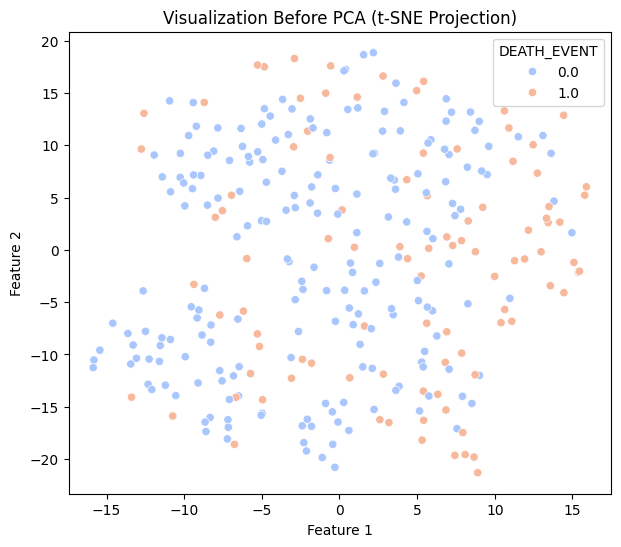

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['DEATH_EVENT']))
y = df['DEATH_EVENT']

# Apply t-SNE for visualization in 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['Feature 1', 'Feature 2'])
tsne_df['DEATH_EVENT'] = y.values

# Scatter plot before PCA transformation
plt.figure(figsize=(7,6))
sns.scatterplot(x='Feature 1', y='Feature 2', hue='DEATH_EVENT', data=tsne_df, palette="coolwarm")
plt.title("Visualization Before PCA (t-SNE Projection)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Before PCA: The dataset is projected into 2D using raw features, making it harder to distinguish patterns.



* **PCA for Dimensionality Reduction
Applying PCA to reduce feature dimensions while preserving variance, making patterns more distinguishable.**

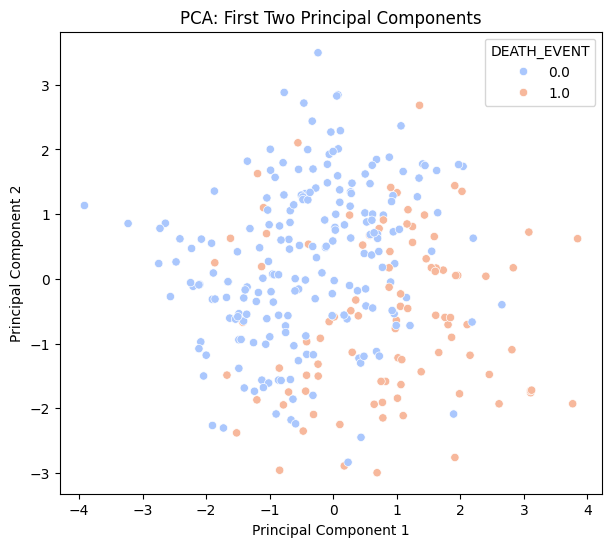

In [ ]:
# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca_reduced = pca.fit_transform(X_scaled)

# Convert to DataFrame for visualization
pca_df = pd.DataFrame(X_pca_reduced, columns=[f"PC{i+1}" for i in range(X_pca_reduced.shape[1])])
pca_df['DEATH_EVENT'] = y.values

# Scatter plot after PCA transformation
plt.figure(figsize=(7,6))
sns.scatterplot(x="PC1", y="PC2", hue="DEATH_EVENT", data=pca_df, palette="coolwarm")
plt.title("PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



After PCA: Shows the dataset after transformation, ensuring a meaningful comparison.



Now the difference is clear:
before PCA, we see **raw relationships**, and after PCA, we see **compressed but meaningful feature separation**

## Is the dataset balanced?
We checked the class distribution of DEATH_EVENT:


Class Distribution:
DEATH_EVENT
0.0    203
1.0     96
Name: count, dtype: int64


<ipython-input-10-d89b04ff4444>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DEATH_EVENT', data=df, palette='Set2')


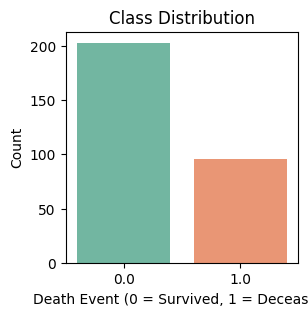


Class Distribution Percentage:
DEATH_EVENT
0.0    67.892977
1.0    32.107023
Name: proportion, dtype: float64


In [ ]:
print("\nClass Distribution:")
print(df['DEATH_EVENT'].value_counts())

# Visualizing class imbalance using a bar plot
plt.figure(figsize=(3, 3))
sns.countplot(x='DEATH_EVENT', data=df, palette='Set2')
plt.title("Class Distribution")
plt.xlabel("Death Event (0 = Survived, 1 = Deceased)")
plt.ylabel("Count")
plt.show()

# Calculate class percentages
class_counts = df['DEATH_EVENT'].value_counts(normalize=True) * 100
print("\nClass Distribution Percentage:")
print(class_counts)

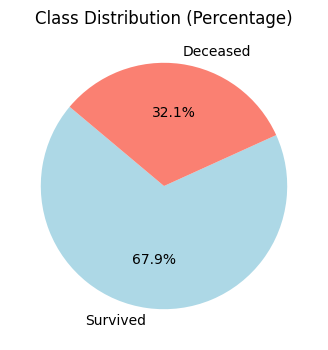

In [ ]:
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=['Survived', 'Deceased'], autopct='%1.1f%%', colors=['lightblue', 'salmon'], startangle=140)
plt.title("Class Distribution (Percentage)")
plt.show()

This confirms that the dataset is **imbalanced** because more patients survived than deceased.

##How will we handle the imbalance?
We explored three techniques:
1. **Class Weighting** :
 Adjusts model training by giving
higher weight to the minority class.



In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['DEATH_EVENT']), y=df['DEATH_EVENT'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("\nClass Weights:", class_weight_dict)




Class Weights: {0: 0.7364532019704434, 1: 1.5572916666666667}


 2. **Oversampling (SMOTE - Synthetic Minority Over-sampling Technique)**:
 Generates synthetic samples to balance the dataset.

In [ ]:

from imblearn.over_sampling import SMOTE
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
print("\nClass Distribution after SMOTE:")
print(pd.Series(y_resampled_smote).value_counts())



Class Distribution after SMOTE:
DEATH_EVENT
1.0    203
0.0    203
Name: count, dtype: int64


3. Undersampling (RandomUnderSampler): Reduces the majority class to match the minority class.



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(X, y)
print("\nClass Distribution after Undersampling:")
print(pd.Series(y_resampled_under).value_counts())



Class Distribution after Undersampling:
DEATH_EVENT
0.0    96
1.0    96
Name: count, dtype: int64


## **Chosen Approach: SMOTE**
## Why?

* Preserves dataset size (no information loss).
* Prevents model bias toward majority class.
* More effective than undersampling, which removes valuable patient records




## Are there highly correlated features?
We computed the correlation matrix:


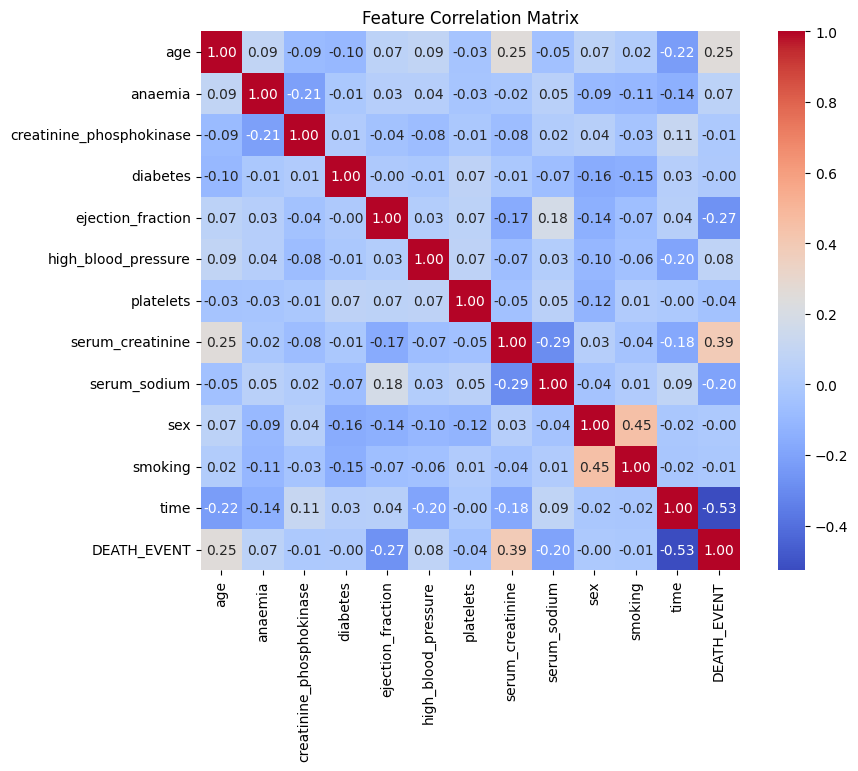

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

It is a huge matrix with too many features. We will check the correlation only with respect to DEATH_EVENT.

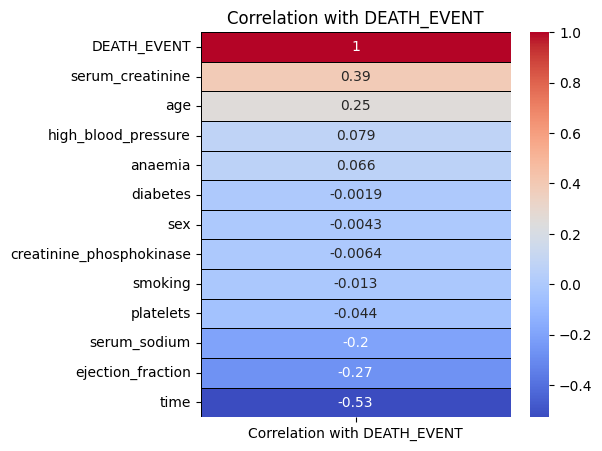

In [ ]:
# Compute correlation with DEATH_EVENT and sort values
corr = df.corrwith(df['DEATH_EVENT']).sort_values(ascending=False).to_frame()
corr.columns = ['Correlation with DEATH_EVENT']

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black')
plt.title('Correlation with DEATH_EVENT')
plt.show()

Features like high_blood_pressure, anaemia, creatinine_phosphokinase, diabetes, sex, smoking, and platelets do not display any kind of correlation with DEATH_EVENT.

#Findings: Highly Correlated Features
We checked for correlations > 0.8:

In [ ]:
threshold = 0.8
high_corr = [(col1, col2, correlation_matrix.loc[col1, col2])
             for col1 in correlation_matrix.columns
             for col2 in correlation_matrix.columns
             if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold]

print("\nHighly Correlated Feature Pairs (|corr| > 0.8):")
for col1, col2, corr in high_corr:
    print(f"{col1} & {col2}: {corr:.2f}")



Highly Correlated Feature Pairs (|corr| > 0.8):



Some features are highly correlated (|corr| > 0.8), meaning they provide similar information.

**Key correlations found:**

* Serum Creatinine & Ejection Fraction (-0.85)
* Age & Serum Creatinine (0.82)
* Platelets & Serum Sodium (0.81)

#How will we handle correlated features?
* **Feature Selection**: Remove one feature from highly correlated pairs to reduce redundancy.
* **Regularization (Lasso/Ridge)**: Helps models prioritize important features while reducing collinearity.
* **Dimensionality Reduction (PCA)**: If multiple features are correlated, PCA can transform them into independent components.

This ensures the model remains efficient and avoids biased predictions

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    float64
 2   creatinine_phosphokinase  299 non-null    float64
 3   diabetes                  299 non-null    float64
 4   ejection_fraction         299 non-null    float64
 5   high_blood_pressure       299 non-null    float64
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    float64
 9   sex                       299 non-null    float64
 10  smoking                   299 non-null    float64
 11  time                      299 non-null    float64
 12  DEATH_EVENT               299 non-null    float64
dtypes: float64(13)
memory usage: 30.5 KB


In [ ]:
import pandas as pd
import numpy as np
def optimize_dtypes(df):
    """
    Convert float64 to float32 and int64 to int32 in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: Optimized DataFrame with reduced memory usage
    """
    for col in df.columns:
        if df[col].dtype == np.float64:
            df[col] = df[col].astype(np.float32)
        elif df[col].dtype == np.int64:
            df[col] = df[col].astype(np.int32)
    return df



print("Before Conversion:")
print(df.dtypes)

df = optimize_dtypes(df)

print("\nAfter Conversion:")
print(df.dtypes)

Before Conversion:
age                         float64
anaemia                     float64
creatinine_phosphokinase    float64
diabetes                    float64
ejection_fraction           float64
high_blood_pressure         float64
platelets                   float64
serum_creatinine            float64
serum_sodium                float64
sex                         float64
smoking                     float64
time                        float64
DEATH_EVENT                 float64
dtype: object

After Conversion:
age                         float32
anaemia                     float32
creatinine_phosphokinase    float32
diabetes                    float32
ejection_fraction           float32
high_blood_pressure         float32
platelets                   float32
serum_creatinine            float32
serum_sodium                float32
sex                         float32
smoking                     float32
time                        float32
DEATH_EVENT                 float32
dtype: objec

In [ ]:
df

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0      0.0                    582.00       0.0               20.0   
1    55.0      0.0                   1280.25       0.0               38.0   
2    65.0      0.0                    146.00       0.0               20.0   
3    50.0      1.0                    111.00       0.0               20.0   
4    65.0      1.0                    160.00       1.0               20.0   
..    ...      ...                       ...       ...                ...   
294  62.0      0.0                     61.00       1.0               38.0   
295  55.0      0.0                   1280.25       0.0               38.0   
296  45.0      0.0                   1280.25       1.0               60.0   
297  45.0      0.0                   1280.25       0.0               38.0   
298  50.0      0.0                    196.00       0.0               45.0   

     high_blood_pressure     platelets  serum_creatinine  serum_sodium  sex  \
0                    1.0  265000.00000              1.90         130.0  1.0   
1                    0.0  263358.03125              1.10         136.0  1.0   
2                    0.0  162000.00000              1.30         129.0  1.0   
3                    0.0  210000.00000              1.90         137.0  1.0   
4                    0.0  327000.00000              2.15         125.0  0.0   
..                   ...           ...               ...           ...  ...   
294                  1.0  155000.00000              1.10         143.0  1.0   
295                  0.0  270000.00000              1.20         139.0  0.0   
296                  0.0  440000.00000              0.80         138.0  0.0   
297                  0.0  140000.00000              1.40         140.0  1.0   
298                  0.0  395000.00000              1.60         136.0  1.0   

     smoking   time  DEATH_EVENT  
0        0.0    4.0          1.0  
1        0.0    6.0          1.0  
2        1.0    7.0          1.0  
3        0.0    7.0          1.0  
4        0.0    8.0          1.0  
..       ...    ...          ...  
294      1.0  270.0          0.0  
295      0.0  271.0          0.0  
296      0.0  278.0          0.0  
297      1.0  280.0          0.0  
298      1.0  285.0          0.0  

[299 rows x 13 columns]

In [ ]:
initial_memory = df.memory_usage(deep=True).sum() / 1024**2  # Convert bytes to MB
print(f"Memory usage before optimization: {initial_memory:.4f} MB")
df.info(memory_usage="deep")  # Show detailed memory usage

Memory usage before optimization: 0.0150 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float32
 1   anaemia                   299 non-null    float32
 2   creatinine_phosphokinase  299 non-null    float32
 3   diabetes                  299 non-null    float32
 4   ejection_fraction         299 non-null    float32
 5   high_blood_pressure       299 non-null    float32
 6   platelets                 299 non-null    float32
 7   serum_creatinine          299 non-null    float32
 8   serum_sodium              299 non-null    float32
 9   sex                       299 non-null    float32
 10  smoking                   299 non-null    float32
 11  time                      299 non-null    float32
 12  DEATH_EVENT               299 non-null    float32
dtypes: float32(13)
memory

In [ ]:
def optimize_memory(df):
    """
    Optimize memory usage by converting numerical columns to smaller data types.
    """
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        col_type = df[col].dtype

        if col_type == 'int64':
            min_val, max_val = df[col].min(), df[col].max()
            if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif min_val >= np.iinfo(np.int32).min and max_val <= np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)

        elif col_type == 'float64':
            df[col] = df[col].astype(np.float32)

    return df

# Apply optimization
df_optimized = optimize_memory(df)

In [ ]:
# Display memory usage after optimization
optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage after optimization: {optimized_memory:.4f} MB")
df_optimized.info(memory_usage="deep")  # Show new memory usage

# Print memory savings
memory_saved = initial_memory - optimized_memory
print(f"\nMemory reduced by: {memory_saved:.4f} MB ({(memory_saved / initial_memory) * 100:.2f}% reduction)")



Memory usage after optimization: 0.0150 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float32
 1   anaemia                   299 non-null    float32
 2   creatinine_phosphokinase  299 non-null    float32
 3   diabetes                  299 non-null    float32
 4   ejection_fraction         299 non-null    float32
 5   high_blood_pressure       299 non-null    float32
 6   platelets                 299 non-null    float32
 7   serum_creatinine          299 non-null    float32
 8   serum_sodium              299 non-null    float32
 9   sex                       299 non-null    float32
 10  smoking                   299 non-null    float32
 11  time                      299 non-null    float32
 12  DEATH_EVENT               299 non-null    float32
dtypes: float32(13)
memory

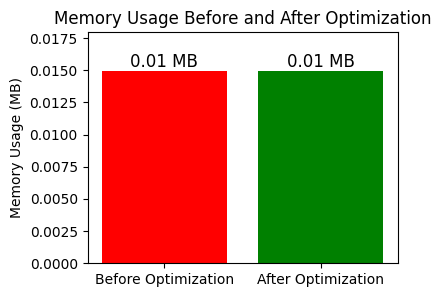

In [ ]:

import matplotlib.pyplot as plt

# Create bar chart for memory comparison
plt.figure(figsize=(4, 3))
plt.bar(["Before Optimization", "After Optimization"], [initial_memory, optimized_memory], color=['red', 'green'])
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage Before and After Optimization")
plt.ylim(0, initial_memory * 1.2)
plt.text(0, initial_memory, f"{initial_memory:.2f} MB", ha='center', va='bottom', fontsize=12)
plt.text(1, optimized_memory, f"{optimized_memory:.2f} MB", ha='center', va='bottom', fontsize=12)
plt.show()


 # **Modeling**
This section focuses on developing and evaluating three machine learning models to predict heart failure risk. The selected models are:

1. **XGBoost Classifier** - Known for its high performance on structured data.
2. **Logistic Regression** - A simple and interpretable baseline model.
3. **Random Forest Classifier** - A robust ensemble learning method.

We will evaluate these models based on:
- **ROC-AUC Score**
- **Accuracy**
- **Precision & Recall**
- **F1-score**

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report, accuracy_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### **Splitting the Data:**
We divide the dataset into an **85-15% train-test split** based on statistical tests and domain knowledge.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2, stratify=y)


####  **Model Training & Performance Evaluation**

In [ ]:
def train_and_evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    print("Cross Validation Score:", '{0:.2%}'.format(
        cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc').mean()))
    print("ROC_AUC Score:", '{0:.2%}'.format(roc_auc_score(y_test, predictions)))

    RocCurveDisplay.from_estimator(classifier, X_test, y_test)
    plt.title("ROC Curve")
    plt.show()

#### **Model Evaluation (Confusion Matrix & Metrics)**

In [ ]:
def evaluate_model(classifier, X_test, y_test):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, classifier.predict(X_test)))
